### Import packages

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame
from shapely.geometry import Polygon
import matplotlib as mpl
import urllib.request
import json
from requests.exceptions import HTTPError
from urllib.error import URLError

###  Housekeeping

The chunk below sets the size of the plots, creates objects referenced further down, and indicates a crs value.

In [101]:
%matplotlib inline 
mpl.rcParams['figure.figsize'] = (14,14)

short_drive_true = True
no_data = 'No data'
dt_1 = 'less than 30 minutes'
dt_2 = '30 minutes to 1 hour'
dt_3 = '1 or more hours'
nan = 'np.nan'
buff = .05

bing_api_key = 'YOUR_API_KEY HERE'

crs = {'init': 'epsg:4326'}

### Load geospatial data

Here I load and subset geospatial data. I create an object called *wa* which is a geospatial object of just Washington state.

You can find the shapefile data <a href="https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html">
here</a>. 

In [73]:
us = gpd.read_file('data/us_states')

wa = us[us['STUSPS']=="WA"]

### Create a grid of points that covers Washington

These are the points with which you calculate travel times from the nooks and crannies of Washington State to community colleges.

In [79]:
by = .05

pts_grid = (
    pd.concat([pd.DataFrame({'pts_lon' : np.arange(wa.bounds['minx'], wa.bounds['maxx'], by)})
               , (pd.DataFrame({'pts_lat' : np.arange(wa.bounds['miny'], wa.bounds['maxy'], by)})
                  .pivot(columns = 'pts_lat', values = 'pts_lat'))]
        , axis = 1
             )
    .replace(method='ffill')
    .replace(method='bfill')
    .melt(id_vars=['pts_lon'])
    .drop('variable', 1)
    .rename(columns = {'value' : 'pts_lat'})
    .reset_index()
    .rename(columns={"index": "point_id"})
)

##### Here is what the points look like

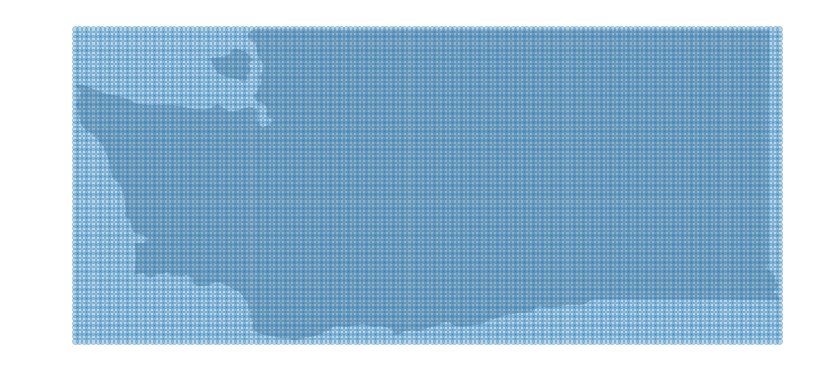

In [75]:
geometry_pts = [Point(xy) for xy in zip(pts_grid.pts_lon, pts_grid.pts_lat)]
gdf_pts_grid = GeoDataFrame(pts_grid, crs=crs, geometry=geometry_pts)

wa_plot = wa.plot(color='#C4C9CE', edgecolor='white')

(
    gdf_pts_grid
        .plot(ax=wa_plot, alpha = .3)
        .set_axis_off()
)

### Create a dataframe from college lon/lat data

Creating a dataframe like this is a little tacky, but it makes it easy for others to read the data and it takes little effort from me.

In [76]:
colleges = pd.DataFrame(data = {
    'college_id' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
            , 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24
            , 25, 26, 27, 28]
    , 'college' : ['Bates Technical College', 'Bellevue College', 'Big Bend Community College'
                 , 'Centralia College', 'Clark College', 'Clover Park Technical College'
                 , 'Columbia Basin College', 'Edmonds Community College', 'Everett Community College'
                 , 'Grays Harbor College', 'Green River College', 'Highline College '
                 , 'Lake Washington Institute of Technology', 'Lower Columbia College', 'North Seattle College'
                 , 'Olympic College', 'Peninsula College', 'Pierce College'
                 , 'Renton Technical College', 'Seattle Central College', 'Shoreline Community College'
                 , 'Skagit Valley College', 'South Puget Sound', 'Spokane Falls Community College'
                 , 'Walla Walla Community College', 'Wenatchee Valley College', 'Whatcom Community College'
                 , 'Yakima Valley College']
    , 'lon' : [-122.44641, -122.1469595, -119.327665, -122.9614303
               , -122.4819369, -122.4979866, -119.1213581, -122.3275206
               , -122.2026286, -123.8012171, -122.1778941, -122.3025025
               , -122.1673284, -122.938378, -122.3325518, -123.1107223
               , -124.3850477, -122.2117983, -122.1761368, -122.321497
               , -122.3598849, -122.3101433, -122.4345806, -117.4639762
               , -118.2778137, -120.3366846, -122.496182, -120.5108421]
    , 'lat' : [47.251503, 47.5851216, 47.1831758, 46.7204489
               , 45.61646345, 47.17475105, 46.2534703, 47.8173949
               , 48.005767, 46.95515005, 47.31394235, 47.38802945
               , 47.7047684, 46.1423913, 47.69870805, 47.2293791
               , 47.9461377, 47.0022547, 47.491597, 47.61643685
               , 47.7489752, 48.43769325, 47.8331514, 47.67642995
               , 46.0792738, 47.43171075, 48.79658105, 46.601557]
})

##### Here is what the college points look like when plotted

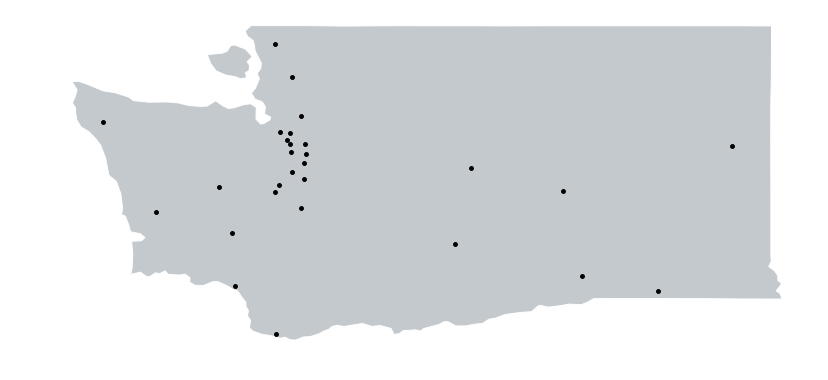

In [77]:
wa_plot = wa.plot(color='#C4C9CE', edgecolor='white')

geometry_col = [Point(xy) for xy in zip(college.lon, college.lat)]

gdf_college = GeoDataFrame(college, crs=crs, geometry=geometry_col)

(
    gdf_college
        .plot(ax = wa_plot, marker='o', color = 'black', markersize=15)
        .set_axis_off()
)

### Calculate drive times between the WA state points and college lon/lat data

Before you do this, you need to create a Bing Maps account (<a href="https://www.bingmapsportal.com/?lc=1033">click here</a>). You also need other stuff to do in the meantime because this code takes about a full day to run. 

Note: Bing may identify you as a corporate user in which case they revoke your API privileges. If this happens, you can create a new account or spend the money to upgrade your user account.

In [100]:
data = (
    pts_grid
    .assign(key = 1)
    .merge(colleges.assign(key = 1), on = 'key')
    .drop('key', axis = 1)
)

time = []
row = []

for i in range(data.shape[0]):
    
    try:
        url = "http://dev.virtualearth.net/REST/V1/Routes/Driving?wp.0=" + str(data.pts_lat[i]) + "," + str(data.pts_lon[i]) + "&wp.1=" + str(data.lat[i]) + "," + str(data.lon[i]) + "&key=" + bing_api_key
        request = urllib.request.Request(url)
        response = urllib.request.urlopen(request)
    except HTTPError:
        row.append(i)
        time.append(np.nan)    
    except URLError:
        row.append(i)
        time.append(np.nan)
    else:
        r = response.read().decode(encoding="utf-8")
        result = json.loads(r)
        row.append(i)
        time.append(result["resourceSets"][0]["resources"][0]["travelDurationTraffic"])

print('finished')

### Process the drive time data you just collected using the Bing Maps API

The drive times Bing gives you are in seconds. I convert them into hours. I also create a variable called time_cat.

Other things I do below are identify the college closest to each point, filter the data based on the shortest travel time, and union the dataframe to itself a couple of times. To create a polygon (in the next chunk), a polygon needs three or more points. This union-ing trick ensures a minimum of three points per polygon. Fewer than three points results in an error.

In [48]:
drive_times = (data
              .assign(time = time / 60 / 60)
              .assign(time_cat = lambda x: np.where(x.time >= 1, '1 or more hours',
                                np.where(x.time >= .5, '30 minutes to 1 hour',
                                np.where(x.time >=0, 'less than 30 minutes', 'No data')))
                     )
              .query('~(time_cat == @no_data)')
             )

min_times = (drive_times
             .groupby('pts_id')['time']
             .min()
             .reset_index()
            )

drive_times = (
    drive_times
        .merge(min_times, on = 'pts_id', how = 'left')
        .assign(shortest_time = lambda x: x.time_x == x.time_y)
        .query('shortest_time == @short_drive_true')
        .sort_values(['pts_id'])
    )

drive_times = pd.concat([drive_times, drive_times, drive_times])

### Process the geospatial data

Here we create polygons based on the time_cat and college variables. I also trim the polygons so that polygons representing shorter drive times are rendered in case of overlap. I also trim polygons based on the WA state boundaries.

In [109]:
geometry = [Point(xy) for xy in zip(drive_times.pts_lon, drive_times.pts_lat)]

gdf_drive_times = GeoDataFrame(drive_times, crs=crs, geometry=geometry)

gdf = (
    gdf_drive_times
    .assign(geometry = lambda x: x['geometry'].apply(lambda x: x.coords[0]))
    .groupby(['college', 'time_cat'])['geometry']
    .apply(lambda x: Polygon(x.tolist()))
    .reset_index()
)

gdf = (
    GeoDataFrame(gdf, crs=crs, geometry = 'geometry')
    .assign(geometry = lambda x: x['geometry'].buffer(buff))
)

gdf_less_30 = gdf.query('time_cat==@dt_1')

gdf_30_to_1hr = gpd.overlay(gdf.query('time_cat==@dt_2'), gdf_less_30, how='difference')

gdf_more_1hr = gpd.overlay(
    gpd.overlay(gdf.query('time_cat==@dt_3'), gdf_less_30, how='difference')
    , gdf_30_to_1hr
    , how='difference'
)

gdf_trimmed = GeoDataFrame(
    pd.concat([gdf_less_30
               , gdf_30_to_1hr
               , gdf_more_1hr]
              , sort=True
              , ignore_index=True
             )
    , crs=crs
    , geometry='geometry'
)

gdf_trimmed = gpd.overlay(gdf_trimmed, wa, how='intersection')

gdf_trimmed.crs = crs

### Plot the drive time polygons and college points

You can see that some areas on the map are NULL. I did not mind this. They are easy to deal with if need be. Consider additional buffering or the *dissolve* function from shapely.

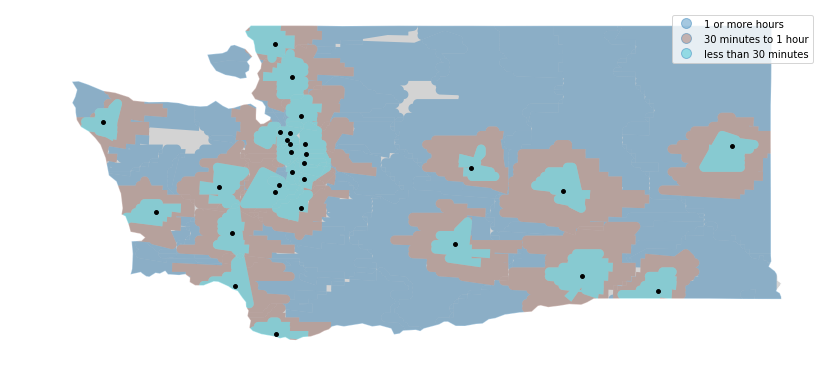

In [110]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

wa.plot(ax=ax, color='lightgrey', edgecolor='white')

(
    gdf_trimmed
        .plot(ax=ax, alpha = .4, column='time_cat', legend=True)
        .set_axis_off()
)

(
    gdf_college
        .plot(ax=ax, marker='o', color = 'black', markersize=15)
        .set_axis_off()
)

plt.show();